<a href="https://colab.research.google.com/github/anetanowak55/Aneta-Nowak-repo/blob/main/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Importy

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# !sudo pip install tensorflowjs
# !pip show tensorflow
# !pip show keras
# !python -V

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflowjs as tfjs

#1. Konfiguracja

In [9]:
SEED=123
np.random.seed(SEED)

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
base_path = "drive/MyDrive/ColabNotebooks/"
path_train_csv = "train.csv"
path_test_csv = "test.csv"
#path_train_img = base_path + "full_train_imgs/train"
path_train_img = base_path + "equal_classes_imgs/train"
path_test_img = base_path + "jpeg/test"
checkpoint_path = base_path + "checkpoint/"
tfjs_target_dir = base_path + "/tfjs"
models_path = base_path + '/models'

In [12]:
CONFIG = dict(
    # Preprocessing
    validation = 0.25,
    target_size = (224,224),
    input_shape = (224, 224, 3),

    # Training
    epochs = 20,
    verbose = 1,
    workers = 4,
    optimizer = 'adam', # 'SGD', 'RMSprop', 'adam'
    RANDOM_STATE = 123,
    loss = 'binary_crossentropy', # focal loss

    # Postprocessing
    label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;
)

#2. Wczytanie i eksploracja danych

In [13]:
train_df = pd.read_csv(base_path + path_train_csv)
train_df['image_filename'] = train_df['image_name'].astype(str) + ".jpg"
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_filename
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,ISIC_2637011.jpg
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,ISIC_0015719.jpg
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,ISIC_0052212.jpg
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,ISIC_0068279.jpg
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,ISIC_0074268.jpg
...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,ISIC_9999134.jpg
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,ISIC_9999320.jpg
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,ISIC_9999515.jpg
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,ISIC_9999666.jpg


In [14]:
train_df.groupby('benign_malignant').size()

benign_malignant
benign       32542
malignant      584
dtype: int64

In [15]:
# # Create a dataset with equal number of malignant and benign cases.

# b, m = train_df.groupby('benign_malignant')
# b[1].drop(b[1].index[584:], inplace=True)
# b = b[1]
# m = m[1]
# train_df=pd.concat([m[1], b[1]])
# train_df.groupby('benign_malignant').size()

#3. Zapisanie obrazów w odpowiedniej strukturze katalogów

In [16]:
# b, m = train_df.groupby('benign_malignant')
# b = b[1]
# m = m[1]

In [17]:
# path = base_path + '/imgg/malignant/'
# for item in m['image_filename']:
#   img = Image.open(base_path+"jpeg/train/"+item)
#   img.save(path+item)

In [18]:
# import shutil

# path = base_path + '/imgg/benign/'
# count = 0

# for item in b['image_filename']:
#   shutil.copyfile(base_path+"jpeg/train/"+item, path+item)
#   count += 1

# count

In [19]:
# Create a train_df that uses % of each label (benign and malignant). Used for quicker adjusting model config.

# train_df = train_df.groupby('benign_malignant', group_keys=False).apply(lambda x: x.sample(frac=CONFIG.get('frac')))
# train_df.groupby('benign_malignant').size()

In [20]:
test_df = pd.read_csv(base_path + path_test_csv)
test_df['image_filename'] = test_df['image_name'].astype(str) + ".jpg"

#old

In [21]:
# # making sure the proportion of classes is equal in train and validation set
# train_train, train_valid = train_test_split(train_df, test_size=CONFIG.get("validation"), stratify=train_df['benign_malignant'])
# train_df_stratified = pd.concat([train_train, train_valid])
# train_df_stratified

In [22]:
# # ref: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

# datagen = ImageDataGenerator(validation_split=CONFIG.get("validation")) # todo image augmentation??

# train_generator = datagen.flow_from_dataframe(
#   dataframe = train_train,
#   directory = path_train_img,
#   x_col = "image_filename",
#   y_col = "benign_malignant",
#   subset="training",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = "categorical",
#   target_size = CONFIG.get("target_size"))

# valid_generator = datagen.flow_from_dataframe(
#   dataframe = train_valid,
#   directory = path_train_img,
#   x_col = "image_filename",
#   y_col = "benign_malignant",
#   subset="validation",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = "categorical",
#   target_size = CONFIG.get("target_size"))

# test_datagen = ImageDataGenerator()

# test_generator = valid_generator = datagen.flow_from_dataframe(
#   dataframe = test_df,
#   directory = path_test_img,
#   x_col = "image_filename",
#   y_col = None,
#   subset = "validation",
#   batch_size = 32,
#   seed = SEED,
#   shuffle = False,
#   class_mode = None,
#   target_size = CONFIG.get("target_size"))

In [23]:
# train_dir = base_path + '/img'
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="training", seed=SEED)
# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="validation",seed=SEED)

# class_names = train_ds.class_names
# num_classes = len(class_names)
# print('\n{} classes:\n{}'.format(num_classes,class_names))

#4. Przygotowanie zbiorów danych treningowych i testowych

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(path_train_img,
                                                    subset='training', 
                                                    target_size=CONFIG.get("target_size"),
                                                    batch_size = 16,
                                                    class_mode='categorical',
                                                    )

valid_generator = train_datagen.flow_from_directory(path_train_img,
                                                     subset='validation', 
                                                     target_size=CONFIG.get("target_size"),
                                                     batch_size = 16,
                                                     class_mode='categorical'
                                                     ) 

class_names = train_generator.class_indices
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))

Found 818 images belonging to 2 classes.
Found 350 images belonging to 2 classes.

2 classes:
{'benign': 0, 'malignant': 1}


In [25]:
from collections import Counter

counter_train = Counter(train_generator.classes)
ratio_train = round(counter_train.get(1) / counter_train.get(0), 3)
print("TRAINING >> {}, ratio malignant/benign: {}".format(counter_train.items(), ratio_train))

counter_valid = Counter(valid_generator.classes)
ratio_valid = round(counter_valid.get(1) / counter_valid.get(0), 3)
print("VALIDATION >> {}, ratio malignant/benign: {}".format(counter_valid.items(), ratio_valid))

TRAINING >> dict_items([(0, 409), (1, 409)]), ratio malignant/benign: 1.0
VALIDATION >> dict_items([(0, 175), (1, 175)]), ratio malignant/benign: 1.0


#old

Focal loss - function that addresses class imbalance during training in tasks like object detection

Ref: https://github.com/mkocabas/focal-loss-keras

In [26]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

#5. Równoważenie klas

In [48]:
# ref: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
n_benign = 32542
n_malignant = 584
total=n_benign + n_malignant

weight_for_malignant = (1 / n_malignant) * (total / 2.0)
weight_for_benign = (1 / n_benign) * (total / 2.0)

class_weight = {0: weight_for_benign, 1: weight_for_malignant}

print('Weight for class 0: {:.2f}'.format(weight_for_benign))
print('Weight for class 1: {:.2f}'.format(weight_for_malignant))

Weight for class 0: 0.51
Weight for class 1: 28.36


#6. Przygotowanie modelu

In [38]:
model_ResNet50 = tf.keras.Sequential([
     tf.keras.applications.ResNet50(
        input_shape = CONFIG.get("input_shape"),
        weights = 'imagenet', # one of None (random initialization), 
                              # 'imagenet' (pre-training on ImageNet) - default,
                              # or the path to the weights file to be loaded
        include_top = False # include the fully-connected layer at the top of the network
    ),
    
    GlobalAveragePooling2D(),
    
    Dense(num_classes, activation='softmax')
])

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
    
model_ResNet50.compile(
    optimizer = CONFIG.get("optimizer"),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CONFIG.get("label_smooth_fac")),
    loss = CONFIG.get('loss'), #[focal_loss(alpha=.25, gamma=2)],
    metrics = METRICS
)

model_ResNet50.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [39]:
# freeze the first layer - reduce significantly number of trainable parameters
# (excluded from training, weights will never be updated)

model_ResNet50.layers[0].trainable = False
model_ResNet50.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [40]:
#plot_model(model_ResNet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#7. Trenowanie modelu

In [41]:
# ref: https://keras.io/api/callbacks/early_stopping/
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 1)

# ref: https://keras.io/api/callbacks/model_checkpoint/
cb_checkpointer  = ModelCheckpoint(filepath = checkpoint_path+'ResNet50-{epoch:02d}.hdf5',
                                   monitor = 'loss', 
                                   verbose = 1,
                                   save_best_only = True,
                                   mode = 'min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

In [42]:
history = model_ResNet50.fit(train_generator, 
                             epochs = CONFIG.get("epochs"), 
                             workers = CONFIG.get("workers"),
                             validation_data = valid_generator,
                             callbacks = callbacks_list 
                            )

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.8634 - tp: 525.0000 - fp: 293.0000 - tn: 525.0000 - fn: 293.0000 - accuracy: 0.6418 - precision: 0.6418 - recall: 0.6418 - auc: 0.6756 - prc: 0.6454
Epoch 1: loss improved from inf to 0.86338, saving model to drive/MyDrive/ColabNotebooks/checkpoint/ResNet50-01.hdf5
52/52 [==============================] - 87s 1s/step - loss: 0.8634 - tp: 525.0000 - fp: 293.0000 - tn: 525.0000 - fn: 293.0000 - accuracy: 0.6418 - precision: 0.6418 - recall: 0.6418 - auc: 0.6756 - prc: 0.6454 - val_loss: 9046.0576 - val_tp: 175.0000 - val_fp: 175.0000 - val_tn: 175.0000 - val_fn: 175.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.6796 - tp: 556.0000 - fp: 262.0000 - tn: 556.0000 - fn: 262.0000 - accuracy: 0.6797 - precision: 0.6797 - recall: 0.6797 - auc: 0.7312 - prc: 0.7023
Epoch 2: loss improved from 0.8

#8. Ocena modelu

In [43]:
#model_ResNet50.evaluate(valid_generator)

In [44]:
history.history

{'loss': [0.8633822202682495,
  0.6796027421951294,
  0.5990184545516968,
  0.5582518577575684,
  0.5834234356880188],
 'tp': [525.0, 556.0, 599.0, 588.0, 570.0],
 'fp': [293.0, 262.0, 219.0, 230.0, 248.0],
 'tn': [525.0, 556.0, 599.0, 588.0, 570.0],
 'fn': [293.0, 262.0, 219.0, 230.0, 248.0],
 'accuracy': [0.6418092846870422,
  0.6797065734863281,
  0.7322738170623779,
  0.718826413154602,
  0.6968215107917786],
 'precision': [0.6418092846870422,
  0.6797065734863281,
  0.7322738170623779,
  0.718826413154602,
  0.6968215107917786],
 'recall': [0.6418092846870422,
  0.6797065734863281,
  0.7322738170623779,
  0.718826413154602,
  0.6968215107917786],
 'auc': [0.6756213903427124,
  0.7312322854995728,
  0.780512273311615,
  0.7973753213882446,
  0.7700994610786438],
 'prc': [0.6454447507858276,
  0.7023390531539917,
  0.7526341080665588,
  0.7905057072639465,
  0.7581567764282227],
 'val_loss': [9046.0576171875,
  400.21954345703125,
  0.6925714015960693,
  0.6931753754615784,
  0.6931

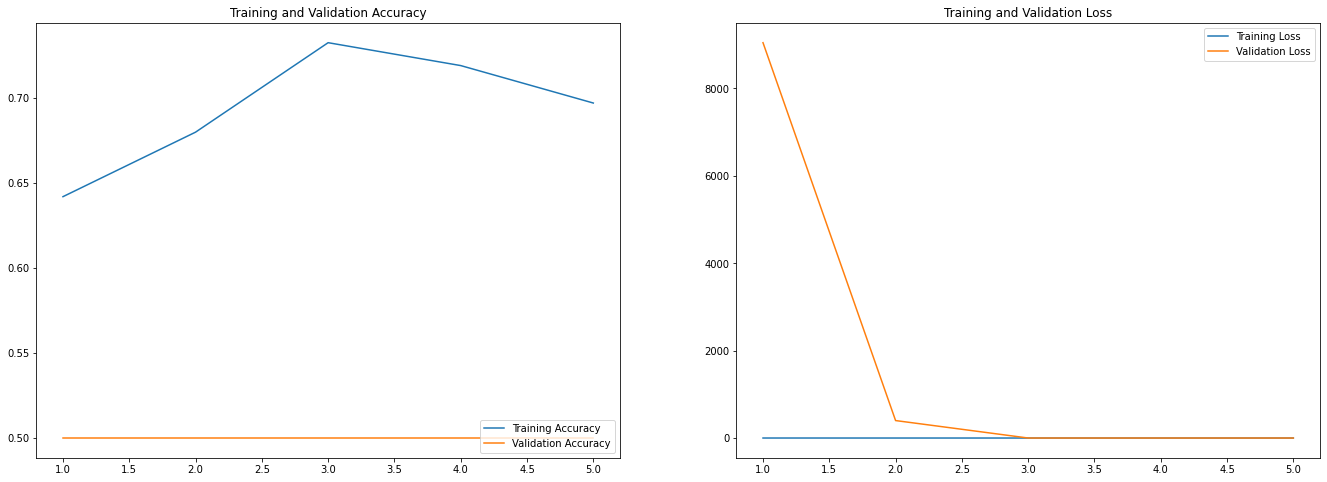

<Figure size 432x288 with 0 Axes>

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig(base_path + "models/imgs/model_2.jpg")

#9. Zapisanie modelu

In [46]:
# Zapisanie w tensorflow.js
#tfjs.converters.save_keras_model(model_ResNet50, tfjs_target_dir, weight_shard_size_bytes=120000000)